<a href="https://colab.research.google.com/github/barakmam/super-resolution/blob/main/MobileNetV3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# imports

In [1]:
import numpy as np
import torch as t
import torchvision.datasets as datasets 
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Subset
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
import matplotlib.pyplot as plt
import time
import copy
!pip install dropblock
from dropblock import DropBlock2D
from dropblock import LinearScheduler as DropBlockScheduled
from collections import OrderedDict

import torch
from torch.hub import load_state_dict_from_url

# Choose Device

In [2]:
# choose device
device = t.device('cuda' if t.cuda.is_available() else 'cpu')
if device.type == 'cuda':
    print("Device: {}".format(t.cuda.get_device_name(0)))
print("Device type: {}".format(device))

Device: Tesla K80
Device type: cuda


# Hyperparameters

In [3]:
batch_size = 64

random_seed = 42
np.random.seed(random_seed)
t.backends.cudnn.enabled = False
t.manual_seed(random_seed)

# Get Data and Dataloaders

In [33]:
class AddGaussianNoise(object):
    def __init__(self, mean=0., std=1., device='cpu'):
        self.std = std
        self.mean = mean
        self.device = device

    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size()).to(self.device) * self.std + self.mean
    
    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)

In [ ]:
%%capture
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.1307,), (0.3081,)),
                                transforms.Resize((64, 64))])

mnist_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
mnist_testset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)


In [8]:
train_inds, val_inds = train_test_split(t.arange(len(mnist_dataset.data)), test_size=0.2)

# get dataloaders
train_sampler = t.utils.data.SubsetRandomSampler(train_inds)
val_sampler = t.utils.data.SubsetRandomSampler(val_inds)

train_loader = t.utils.data.DataLoader(mnist_dataset, batch_size=batch_size, sampler=train_sampler)
val_loader = t.utils.data.DataLoader(mnist_dataset, batch_size=batch_size, sampler=val_sampler)
test_loader = t.utils.data.DataLoader(mnist_testset, batch_size=batch_size, shuffle=True)

# Mnist Labels Distribution

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  """Entry point for launching an IPython kernel.


Text(0, 0.5, 'portion')

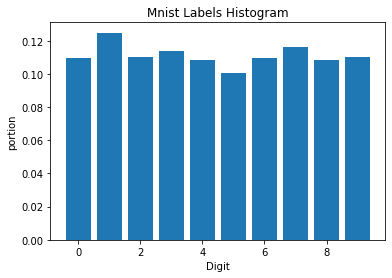

In [17]:
classes_distribution = np.histogram(train_loader.dataset.targets, bins=10, range=(0, 9), normed=True)
plt.bar(range(10), classes_distribution[0])
plt.title('Mnist Labels Histogram')
plt.xlabel('Digit')
plt.ylabel('portion')

# Utils Functions

In [18]:
def evaluate(NN, data_loader, criterion):
    NN.eval()
    correct = 0
    total = 0
    tot_loss = 0
    with t.no_grad():
        for x, y in data_loader:
            x, y = x.to(device), y.to(device)
            output = NN(x)
            loss = criterion(output, y) 
            tot_loss += loss.item()
            correct += (output.argmax(-1) == y).sum()
            total += len(y)
        accuracy = correct/total
        avg_loss = tot_loss/len(data_loader)
    return accuracy, avg_loss

def get_decoder_input(out_E, x, y):
    # need to make some samples without watermarks.
    inds_to_remove_watermark = t.randperm(len(y))[:len(y)//11]
    out_E[inds_to_remove_watermark] = x[inds_to_remove_watermark]
    y[inds_to_remove_watermark] = 10
    return out_E, y

def unite_losses(l2loss, celoss):
    loss = l2loss*10 + celoss/10
    return loss

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    # print(cm)

    fig, ax = plt.subplots(figsize=(10, 10))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')
    fig.subplots_adjust(bottom=0.2)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    plt.setp(ax.get_yticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    # ax.tick_params(labelsize=3)

    # Loop over data dimensions and create text annotations.
    fmt = '.3f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax



# Classifier

In [19]:
def sigmoid(x, inplace: bool = False):
    return x.sigmoid_() if inplace else x.sigmoid()

In [20]:
""" Padding Helpers

Hacked together by Ross Wightman
"""
import math
from typing import List, Tuple

# import torch.nn.functional as F


# Calculate symmetric padding for a convolution
def get_padding(kernel_size: int, stride: int = 1, dilation: int = 1, **_) -> int:
    padding = ((stride - 1) + dilation * (kernel_size - 1)) // 2
    return padding


# Calculate asymmetric TensorFlow-like 'SAME' padding for a convolution
def get_same_padding(x: int, k: int, s: int, d: int):
    return max((math.ceil(x / s) - 1) * s + (k - 1) * d + 1 - x, 0)


# Can SAME padding for given args be done statically?
def is_static_pad(kernel_size: int, stride: int = 1, dilation: int = 1, **_):
    return stride == 1 and (dilation * (kernel_size - 1)) % 2 == 0


# Dynamically pad input x with 'SAME' padding for conv with specified args
def pad_same(x, k: List[int], s: List[int], d: List[int] = (1, 1), value: float = 0):
    ih, iw = x.size()[-2:]
    pad_h, pad_w = get_same_padding(ih, k[0], s[0], d[0]), get_same_padding(iw, k[1], s[1], d[1])
    if pad_h > 0 or pad_w > 0:
        x = F.pad(x, [pad_w // 2, pad_w - pad_w // 2, pad_h // 2, pad_h - pad_h // 2], value=value)
    return x


def get_padding_value(padding, kernel_size, **kwargs) -> Tuple[Tuple, bool]:
    dynamic = False
    if isinstance(padding, str):
        # for any string padding, the padding will be calculated for you, one of three ways
        padding = padding.lower()
        if padding == 'same':
            # TF compatible 'SAME' padding, has a performance and GPU memory allocation impact
            if is_static_pad(kernel_size, **kwargs):
                # static case, no extra overhead
                padding = get_padding(kernel_size, **kwargs)
            else:
                # dynamic 'SAME' padding, has runtime/GPU memory overhead
                padding = 0
                dynamic = True
        elif padding == 'valid':
            # 'VALID' padding, same as padding=0
            padding = 0
        else:
            # Default to PyTorch style 'same'-ish symmetric padding
            padding = get_padding(kernel_size, **kwargs)
    return padding, dynamic

In [21]:
""" Conv2d w/ Same Padding
Hacked together by Ross Wightman
"""
# import torch
# import torch.nn as nn
# import torch.nn.functional as F
from typing import Tuple, Optional

# from .padding import pad_same, get_padding_value


def conv2d_same(
        x, weight: torch.Tensor, bias: Optional[torch.Tensor] = None, stride: Tuple[int, int] = (1, 1),
        padding: Tuple[int, int] = (0, 0), dilation: Tuple[int, int] = (1, 1), groups: int = 1):
    x = pad_same(x, weight.shape[-2:], stride, dilation)
    return F.conv2d(x, weight, bias, stride, (0, 0), dilation, groups)


class Conv2dSame(nn.Conv2d):
    """ Tensorflow like 'SAME' convolution wrapper for 2D convolutions
    """

    def __init__(self, in_channels, out_channels, kernel_size, stride=1,
                 padding=0, dilation=1, groups=1, bias=True):
        super(Conv2dSame, self).__init__(
            in_channels, out_channels, kernel_size, stride, 0, dilation, groups, bias)

    def forward(self, x):
        return conv2d_same(x, self.weight, self.bias, self.stride, self.padding, self.dilation, self.groups)


def create_conv2d_pad(in_chs, out_chs, kernel_size, **kwargs):
    padding = kwargs.pop('padding', '')
    kwargs.setdefault('bias', False)
    padding, is_dynamic = get_padding_value(padding, kernel_size, **kwargs)
    if is_dynamic:
        return Conv2dSame(in_chs, out_chs, kernel_size, **kwargs)
    else:
        return nn.Conv2d(in_chs, out_chs, kernel_size, padding=padding, **kwargs)

In [22]:
""" PyTorch Mixed Convolution

Paper: MixConv: Mixed Depthwise Convolutional Kernels (https://arxiv.org/abs/1907.09595)

Hacked together by Ross Wightman
"""

# import torch
# from torch import nn as nn

# from .conv2d_same import create_conv2d_pad


def _split_channels(num_chan, num_groups):
    split = [num_chan // num_groups for _ in range(num_groups)]
    split[0] += num_chan - sum(split)
    return split


class MixedConv2d(nn.ModuleDict):
    """ Mixed Grouped Convolution

    Based on MDConv and GroupedConv in MixNet impl:
      https://github.com/tensorflow/tpu/blob/master/models/official/mnasnet/mixnet/custom_layers.py
    """
    def __init__(self, in_channels, out_channels, kernel_size=3,
                 stride=1, padding='', dilation=1, depthwise=False, **kwargs):
        super(MixedConv2d, self).__init__()

        kernel_size = kernel_size if isinstance(kernel_size, list) else [kernel_size]
        num_groups = len(kernel_size)
        in_splits = _split_channels(in_channels, num_groups)
        out_splits = _split_channels(out_channels, num_groups)
        self.in_channels = sum(in_splits)
        self.out_channels = sum(out_splits)
        for idx, (k, in_ch, out_ch) in enumerate(zip(kernel_size, in_splits, out_splits)):
            conv_groups = out_ch if depthwise else 1
            # use add_module to keep key space clean
            self.add_module(
                str(idx),
                create_conv2d_pad(
                    in_ch, out_ch, k, stride=stride,
                    padding=padding, dilation=dilation, groups=conv_groups, **kwargs)
            )
        self.splits = in_splits

    def forward(self, x):
        x_split = torch.split(x, self.splits, 1)
        x_out = [c(x_split[i]) for i, c in enumerate(self.values())]
        x = torch.cat(x_out, 1)
        return x

In [23]:
""" PyTorch Conditionally Parameterized Convolution (CondConv)

Paper: CondConv: Conditionally Parameterized Convolutions for Efficient Inference
(https://arxiv.org/abs/1904.04971)

Hacked together by Ross Wightman
"""

# import math
from functools import partial
# import numpy as np
# import torch
# from torch import nn as nn
# from torch.nn import functional as F

# from .helpers import tup_pair
# from .conv2d_same import conv2d_same
# from .padding import get_padding_value


def get_condconv_initializer(initializer, num_experts, expert_shape):
    def condconv_initializer(weight):
        """CondConv initializer function."""
        num_params = np.prod(expert_shape)
        if (len(weight.shape) != 2 or weight.shape[0] != num_experts or
                weight.shape[1] != num_params):
            raise (ValueError(
                'CondConv variables must have shape [num_experts, num_params]'))
        for i in range(num_experts):
            initializer(weight[i].view(expert_shape))
    return condconv_initializer


class CondConv2d(nn.Module):
    """ Conditionally Parameterized Convolution
    Inspired by: https://github.com/tensorflow/tpu/blob/master/models/official/efficientnet/condconv/condconv_layers.py

    Grouped convolution hackery for parallel execution of the per-sample kernel filters inspired by this discussion:
    https://github.com/pytorch/pytorch/issues/17983
    """
    __constants__ = ['in_channels', 'out_channels', 'dynamic_padding']

    def __init__(self, in_channels, out_channels, kernel_size=3,
                 stride=1, padding='', dilation=1, groups=1, bias=False, num_experts=4):
        super(CondConv2d, self).__init__()

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = tup_pair(kernel_size)
        self.stride = tup_pair(stride)
        padding_val, is_padding_dynamic = get_padding_value(
            padding, kernel_size, stride=stride, dilation=dilation)
        self.dynamic_padding = is_padding_dynamic  # if in forward to work with torchscript
        self.padding = tup_pair(padding_val)
        self.dilation = tup_pair(dilation)
        self.groups = groups
        self.num_experts = num_experts

        self.weight_shape = (self.out_channels, self.in_channels // self.groups) + self.kernel_size
        weight_num_param = 1
        for wd in self.weight_shape:
            weight_num_param *= wd
        self.weight = torch.nn.Parameter(torch.Tensor(self.num_experts, weight_num_param))

        if bias:
            self.bias_shape = (self.out_channels,)
            self.bias = torch.nn.Parameter(torch.Tensor(self.num_experts, self.out_channels))
        else:
            self.register_parameter('bias', None)

        self.reset_parameters()

    def reset_parameters(self):
        init_weight = get_condconv_initializer(
            partial(nn.init.kaiming_uniform_, a=math.sqrt(5)), self.num_experts, self.weight_shape)
        init_weight(self.weight)
        if self.bias is not None:
            fan_in = np.prod(self.weight_shape[1:])
            bound = 1 / math.sqrt(fan_in)
            init_bias = get_condconv_initializer(
                partial(nn.init.uniform_, a=-bound, b=bound), self.num_experts, self.bias_shape)
            init_bias(self.bias)

    def forward(self, x, routing_weights):
        B, C, H, W = x.shape
        weight = torch.matmul(routing_weights, self.weight)
        new_weight_shape = (B * self.out_channels, self.in_channels // self.groups) + self.kernel_size
        weight = weight.view(new_weight_shape)
        bias = None
        if self.bias is not None:
            bias = torch.matmul(routing_weights, self.bias)
            bias = bias.view(B * self.out_channels)
        # move batch elements with channels so each batch element can be efficiently convolved with separate kernel
        x = x.view(1, B * C, H, W)
        if self.dynamic_padding:
            out = conv2d_same(
                x, weight, bias, stride=self.stride, padding=self.padding,
                dilation=self.dilation, groups=self.groups * B)
        else:
            out = F.conv2d(
                x, weight, bias, stride=self.stride, padding=self.padding,
                dilation=self.dilation, groups=self.groups * B)
        out = out.permute([1, 0, 2, 3]).view(B, self.out_channels, out.shape[-2], out.shape[-1])

        # Literal port (from TF definition)
        # x = torch.split(x, 1, 0)
        # weight = torch.split(weight, 1, 0)
        # if self.bias is not None:
        #     bias = torch.matmul(routing_weights, self.bias)
        #     bias = torch.split(bias, 1, 0)
        # else:
        #     bias = [None] * B
        # out = []
        # for xi, wi, bi in zip(x, weight, bias):
        #     wi = wi.view(*self.weight_shape)
        #     if bi is not None:
        #         bi = bi.view(*self.bias_shape)
        #     out.append(self.conv_fn(
        #         xi, wi, bi, stride=self.stride, padding=self.padding,
        #         dilation=self.dilation, groups=self.groups))
        # out = torch.cat(out, 0)
        return out

In [24]:
""" Create Conv2d Factory Method

Hacked together by Ross Wightman
"""

# from .mixed_conv2d import MixedConv2d
# from .cond_conv2d import CondConv2d
# from .conv2d_same import create_conv2d_pad


def create_conv2d(in_channels, out_channels, kernel_size, **kwargs):
    """ Select a 2d convolution implementation based on arguments
    Creates and returns one of torch.nn.Conv2d, Conv2dSame, MixedConv2d, or CondConv2d.

    Used extensively by EfficientNet, MobileNetv3 and related networks.
    """
    if isinstance(kernel_size, list):
        assert 'num_experts' not in kwargs  # MixNet + CondConv combo not supported currently
        assert 'groups' not in kwargs  # MixedConv groups are defined by kernel list
        # We're going to use only lists for defining the MixedConv2d kernel groups,
        # ints, tuples, other iterables will continue to pass to normal conv and specify h, w.
        m = MixedConv2d(in_channels, out_channels, kernel_size, **kwargs)
    else:
        depthwise = kwargs.pop('depthwise', False)
        groups = out_channels if depthwise else kwargs.pop('groups', 1)
        if 'num_experts' in kwargs and kwargs['num_experts'] > 0:
            m = CondConv2d(in_channels, out_channels, kernel_size, groups=groups, **kwargs)
        else:
            m = create_conv2d_pad(in_channels, out_channels, kernel_size, groups=groups, **kwargs)
    return m

In [25]:
class ConvBnAct(nn.Module):
    def __init__(self, in_chs, out_chs, kernel_size,
                 stride=1, dilation=1, pad_type='', act_layer=nn.ReLU,
                 norm_layer=nn.BatchNorm2d, norm_kwargs=None):
        super(ConvBnAct, self).__init__()
        norm_kwargs = norm_kwargs or {}
        self.conv = create_conv2d(in_chs, out_chs, kernel_size, stride=stride, dilation=dilation, padding=pad_type)
        self.bn1 = norm_layer(out_chs, **norm_kwargs)
        self.act1 = act_layer(inplace=True)

    def feature_info(self, location):
        if location == 'expansion' or location == 'depthwise':
            # no expansion or depthwise this block, use act after conv
            info = dict(module='act1', hook_type='forward', num_chs=self.conv.out_channels)
        else:  # location == 'bottleneck'
            info = dict(module='', hook_type='', num_chs=self.conv.out_channels)
        return info

    def forward(self, x):
        x = self.conv(x)
        x = self.bn1(x)
        x = self.act1(x)
        return x

In [26]:
def drop_path(x, drop_prob: float = 0., training: bool = False):
    """Drop paths (Stochastic Depth) per sample (when applied in main path of residual blocks).
    This is the same as the DropConnect impl I created for EfficientNet, etc networks, however,
    the original name is misleading as 'Drop Connect' is a different form of dropout in a separate paper...
    See discussion: https://github.com/tensorflow/tpu/issues/494#issuecomment-532968956 ... I've opted for
    changing the layer and argument names to 'drop path' rather than mix DropConnect as a layer name and use
    'survival rate' as the argument.
    """
    if drop_prob == 0. or not training:
        return x
    keep_prob = 1 - drop_prob
    random_tensor = keep_prob + torch.rand((x.size()[0], 1, 1, 1), dtype=x.dtype, device=x.device)
    random_tensor.floor_()  # binarize
    output = x.div(keep_prob) * random_tensor
    return output

In [27]:
def swish(x):
    return x * x.sigmoid()


def hard_sigmoid(x, inplace=False):
    return F.relu6(x + 3, inplace) / 6


def hard_swish(x, inplace=False):
    return x * hard_sigmoid(x, inplace)


class HardSigmoid(nn.Module):
    def __init__(self, inplace=False):
        super(HardSigmoid, self).__init__()
        self.inplace = inplace

    def forward(self, x):
        return hard_sigmoid(x, inplace=self.inplace)


class HardSwish(nn.Module):
    def __init__(self, inplace=False):
        super(HardSwish, self).__init__()
        self.inplace = inplace

    def forward(self, x):
        return hard_swish(x, inplace=self.inplace)


def _make_divisible(v, divisor, min_value=None):
    """
    This function is taken from the original tf repo.
    It ensures that all layers have a channel number that is divisible by 8
    It can be seen here:
    https://github.com/tensorflow/models/blob/master/research/slim/nets/mobilenet/mobilenet.py
    :param v:
    :param divisor:
    :param min_value:
    :return:
    """
    if min_value is None:
        min_value = divisor
    new_v = max(min_value, int(v + divisor / 2) // divisor * divisor)
    # Make sure that round down does not go down by more than 10%.
    if new_v < 0.9 * v:
        new_v += divisor
    return new_v


# https://github.com/jonnedtc/Squeeze-Excitation-PyTorch/blob/master/networks.py
class SqEx(nn.Module):

    def __init__(self, n_features, reduction=4):
        super(SqEx, self).__init__()

        if n_features % reduction != 0:
            raise ValueError('n_features must be divisible by reduction (default = 4)')

        self.linear1 = nn.Linear(n_features, n_features // reduction, bias=True)
        self.nonlin1 = nn.ReLU(inplace=True)
        self.linear2 = nn.Linear(n_features // reduction, n_features, bias=True)
        self.nonlin2 = HardSigmoid(inplace=True)

    def forward(self, x):
        y = F.avg_pool2d(x, kernel_size=x.size()[2:4])
        y = y.permute(0, 2, 3, 1)
        y = self.nonlin1(self.linear1(y))
        y = self.nonlin2(self.linear2(y))
        y = y.permute(0, 3, 1, 2)
        y = x * y
        return y


class LinearBottleneck(nn.Module):
    def __init__(self, inplanes, outplanes, expplanes, k=3, stride=1, drop_prob=0, num_steps=3e5, start_step=0,
                 activation=nn.ReLU, act_params={"inplace": True}, SE=False):
        super(LinearBottleneck, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, expplanes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(expplanes)
        self.db1 = DropBlockScheduled(DropBlock2D(drop_prob=0, block_size=7), start_value=0.,
                                      stop_value=drop_prob, nr_steps=num_steps)
        self.act1 = activation(**act_params)  # first does have act according to MobileNetV2

        self.conv2 = nn.Conv2d(expplanes, expplanes, kernel_size=k, stride=stride, padding=k // 2, bias=False,
                               groups=expplanes)
        self.bn2 = nn.BatchNorm2d(expplanes)
        self.db2 = DropBlockScheduled(DropBlock2D(drop_prob=drop_prob, block_size=7), start_value=0.,
                                      stop_value=drop_prob, nr_steps=num_steps)
        self.act2 = activation(**act_params)

        self.se = SqEx(expplanes) if SE else lambda x: x

        self.conv3 = nn.Conv2d(expplanes, outplanes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(outplanes)
        self.db3 = DropBlockScheduled(DropBlock2D(drop_prob=drop_prob, block_size=7), start_value=0.,
                                      stop_value=drop_prob, nr_steps=num_steps)
        # self.act3 = activation(**act_params)  # works worse

        self.stride = stride
        self.expplanes = expplanes
        self.inplanes = inplanes
        self.outplanes = outplanes

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.db1(out)
        out = self.act1(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.db2(out)
        out = self.act2(out)

        out = self.se(out)

        out = self.conv3(out)
        out = self.bn3(out)
        out = self.db3(out)
        # out = self.act3(out)

        if self.stride == 1 and self.inplanes == self.outplanes:  # TODO: or add 1x1?
            out += residual  # No inplace if there is in-place activation before

        return out


class LastBlockLarge(nn.Module):
    def __init__(self, inplanes, num_classes, expplanes1, expplanes2):
        super(LastBlockLarge, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, expplanes1, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(expplanes1)
        self.act1 = HardSwish(inplace=True)

        self.avgpool = nn.AdaptiveAvgPool2d(1)

        self.conv2 = nn.Conv2d(expplanes1, expplanes2, kernel_size=1, stride=1)
        self.act2 = HardSwish(inplace=True)

        self.dropout = nn.Dropout(p=0.2, inplace=True)
        self.fc = nn.Linear(expplanes2, num_classes)

        self.expplanes1 = expplanes1
        self.expplanes2 = expplanes2
        self.inplanes = inplanes
        self.num_classes = num_classes

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.act1(out)

        out = self.avgpool(out)

        out = self.conv2(out)
        out = self.act2(out)

        # flatten for input to fully-connected layer
        out = out.view(out.size(0), -1)
        out = self.fc(self.dropout(out))

        return out


class LastBlockSmall(nn.Module):
    def __init__(self, inplanes, num_classes, expplanes1, expplanes2):
        super(LastBlockSmall, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, expplanes1, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(expplanes1)
        self.act1 = HardSwish(inplace=True)

        self.se = SqEx(expplanes1)

        self.avgpool = nn.AdaptiveAvgPool2d(1)

        self.conv2 = nn.Conv2d(expplanes1, expplanes2, kernel_size=1, stride=1, bias=False)
        self.act2 = HardSwish(inplace=True)

        self.dropout = nn.Dropout(p=0.2, inplace=True)
        self.fc = nn.Linear(expplanes2, num_classes)

        self.expplanes1 = expplanes1
        self.expplanes2 = expplanes2
        self.inplanes = inplanes
        self.num_classes = num_classes

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.act1(out)

        out = self.se(out)
        out = self.avgpool(out)

        out = self.conv2(out)
        out = self.act2(out)

        # flatten for input to fully-connected layer
        out = out.view(out.size(0), -1)
        out = self.fc(self.dropout(out))

        return out


class SqueezeExcite(nn.Module):
    def __init__(self, in_chs, se_ratio=0.25, reduced_base_chs=None,
                 act_layer=nn.ReLU, gate_fn=sigmoid, divisor=1, **_):
        super(SqueezeExcite, self).__init__()
        self.gate_fn = gate_fn
        reduced_chs = make_divisible((reduced_base_chs or in_chs) * se_ratio, divisor)
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.conv_reduce = nn.Conv2d(in_chs, reduced_chs, 1, bias=True)
        self.act1 = act_layer(inplace=True)
        self.conv_expand = nn.Conv2d(reduced_chs, in_chs, 1, bias=True)

    def forward(self, x):
        x_se = self.avg_pool(x)
        x_se = self.conv_reduce(x_se)
        x_se = self.act1(x_se)
        x_se = self.conv_expand(x_se)
        x = x * self.gate_fn(x_se)
        return x


class DepthwiseSeparableConv(nn.Module):
    """ DepthwiseSeparable block
    Used for DS convs in MobileNet-V1 and in the place of IR blocks that have no expansion
    (factor of 1.0). This is an alternative to having a IR with an optional first pw conv.
    """

    def __init__(self, in_chs, out_chs, dw_kernel_size=3,
                 stride=1, dilation=1, pad_type='', act_layer=nn.ReLU, noskip=False,
                 pw_kernel_size=1, pw_act=False, se_ratio=0., se_kwargs=None,
                 norm_layer=nn.BatchNorm2d, norm_kwargs=None, drop_path_rate=0.):
        super(DepthwiseSeparableConv, self).__init__()
        norm_kwargs = norm_kwargs or {}
        has_se = se_ratio is not None and se_ratio > 0.
        self.has_residual = (stride == 1 and in_chs == out_chs) and not noskip
        self.has_pw_act = pw_act  # activation after point-wise conv
        self.drop_path_rate = drop_path_rate

        self.conv_dw = create_conv2d(
            in_chs, in_chs, dw_kernel_size, stride=stride, dilation=dilation, padding=pad_type, depthwise=True)
        self.bn1 = norm_layer(in_chs, **norm_kwargs)
        self.act1 = act_layer(inplace=True)

        # Squeeze-and-excitation
        # if has_se:
        #     se_kwargs = resolve_se_args(se_kwargs, in_chs, act_layer)
        #     self.se = SqueezeExcite(in_chs, se_ratio=se_ratio, **se_kwargs)
        # else:
        #     self.se = None
        self.se = None


        self.conv_pw = create_conv2d(in_chs, out_chs, pw_kernel_size, padding=pad_type)
        self.bn2 = norm_layer(out_chs, **norm_kwargs)
        self.act2 = act_layer(inplace=True) if self.has_pw_act else nn.Identity()

    def feature_info(self, location):
        if location == 'expansion':
            # no expansion in this block, use depthwise, before SE
            info = dict(module='act1', hook_type='forward', num_chs=self.conv_pw.in_channels)
        elif location == 'depthwise':  # after SE
            info = dict(module='conv_pw', hook_type='forward_pre', num_chs=self.conv_pw.in_channels)
        else:  # location == 'bottleneck'
            info = dict(module='', hook_type='', num_chs=self.conv_pw.out_channels)
        return info

    def forward(self, x):
        residual = x

        x = self.conv_dw(x)
        x = self.bn1(x)
        x = self.act1(x)

        if self.se is not None:
            x = self.se(x)

        x = self.conv_pw(x)
        x = self.bn2(x)
        x = self.act2(x)

        if self.has_residual:
            if self.drop_path_rate > 0.:
                x = drop_path(x, self.drop_path_rate, self.training)
            x += residual
        return x


class ConvBnAct(nn.Module):
    def __init__(self, in_chs, out_chs, kernel_size,
                 stride=1, dilation=1, pad_type='', act_layer=nn.ReLU,
                 norm_layer=nn.BatchNorm2d, norm_kwargs=None):
        super(ConvBnAct, self).__init__()
        norm_kwargs = norm_kwargs or {}
        self.conv = create_conv2d(in_chs, out_chs, kernel_size, stride=stride, dilation=dilation, padding=pad_type)
        self.bn1 = norm_layer(out_chs, **norm_kwargs)
        self.act1 = act_layer(inplace=True)

    def feature_info(self, location):
        if location == 'expansion' or location == 'depthwise':
            # no expansion or depthwise this block, use act after conv
            info = dict(module='act1', hook_type='forward', num_chs=self.conv.out_channels)
        else:  # location == 'bottleneck'
            info = dict(module='', hook_type='', num_chs=self.conv.out_channels)
        return info

    def forward(self, x):
        x = self.conv(x)
        x = self.bn1(x)
        x = self.act1(x)
        return x


class MobileNetV3(nn.Module):
    """MobileNetV3 implementation.
    """

    def __init__(self, input_shape, num_classes=1000, in_channels=3, drop_prob=0.0, start_step=0, num_steps=int(3e5), device='cpu'):
        super(MobileNetV3, self).__init__()

        self.num_classes = num_classes
        self.num_steps = num_steps
        self.start_step = start_step

        self.ds = DepthwiseSeparableConv(in_chs=in_channels, out_chs=16, dw_kernel_size=3,
                 stride=1, dilation=1, pad_type='', act_layer=nn.ReLU, noskip=False,
                 pw_kernel_size=1, pw_act=False, se_ratio=0., se_kwargs=None,
                 norm_layer=nn.BatchNorm2d, norm_kwargs=None, drop_path_rate=0.).to(device)

        # setting of bottlenecks blocks
        self.bottlenecks_setting = [
            # in, exp, out, s, k,         dp,    se,      act
            [16, 16*3, 24, 2, 5, 0, False, nn.ReLU],  # -> 112x112
            [24, 24*3, 24, 1, 5, 0, True, nn.ReLU],  # -> 56x56
            [24, 24*3, 40, 2, 5, 0, False, nn.ReLU],  # -> 56x56
            [40, 40*6, 40, 1, 5, 0, True, nn.ReLU],  # -> 28x28
            [40, 40*6, 80, 2, 5, 0, True, nn.ReLU],  # -> 28x28
            [80, 80*6, 80, 1, 5, 0, True, nn.ReLU],  # -> 28x28
            [80, 80*6, 112, 1, 5, 0, True, nn.ReLU],  # -> 14x14
            [112, 112*6, 112, 1, 5, 0, True, nn.ReLU],  # -> 14x14
            [112, 112*6, 192, 2, 5, 0, True, nn.ReLU],  # -> 14x14
            [192, 192*6, 192, 1, 5, 0, True, nn.ReLU]#,  # -> 14x14
            # [80, 480, 112, 1, 3, drop_prob, True, HardSwish],  # -> 14x14
        ]


        for l in self.bottlenecks_setting:
            l[0] = _make_divisible(l[0], 8)
            l[1] = _make_divisible(l[1], 8)
            l[2] = _make_divisible(l[2], 8)

        self.bottlenecks = self._make_bottlenecks().to(device)

        self.last_layer = ConvBnAct(in_chs=192, out_chs=960, kernel_size=1,
                          stride=1, dilation=1, pad_type='', act_layer=nn.ReLU,
                          norm_layer=nn.BatchNorm2d, norm_kwargs=None).to(device)

        self.num_features = self._get_conv_output((in_channels, input_shape, input_shape))

        self.decode = nn.Sequential(
            nn.ConvTranspose2d(in_channels=960, out_channels=192, kernel_size=4, stride=2, padding=1),
            nn.ConvTranspose2d(in_channels=192, out_channels=80, kernel_size=4, stride=2, padding=1),
            nn.ConvTranspose2d(in_channels=80, out_channels=24, kernel_size=4, stride=2, padding=1),
            nn.ConvTranspose2d(in_channels=24, out_channels=in_channels, kernel_size=4, stride=2, padding=1)
        )
        
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(self.num_features, num_classes)
        )

    def _get_conv_output(self, shape):
          batch_size = 1
          input = torch.autograd.Variable(torch.rand(batch_size, *shape)).cuda()

          input = self.ds(input)
          input = self.bottlenecks(input)
          input = self.last_layer(input)
          # output_feat = self.features(input)
          n_size = input.data.view(batch_size, -1).size(1)
          return n_size


    def _make_bottlenecks(self):
        modules = OrderedDict()
        stage_name = "Bottleneck"

        # add LinearBottleneck
        for i, setup in enumerate(self.bottlenecks_setting):
            name = stage_name + "_{}".format(i)
            module = LinearBottleneck(setup[0], setup[2], setup[1], k=setup[4], stride=setup[3], drop_prob=setup[5],
                                      num_steps=self.num_steps, start_step=self.start_step, activation=setup[7],
                                      act_params={"inplace": True}, SE=setup[6])
            modules[name] = module

        return nn.Sequential(modules)

    def forward(self, x):

        x = self.ds(x)
        x = self.bottlenecks(x)
        x = self.last_layer(x)
        x = self.decode(x)
        # x = x.view(x.size(0), -1)
        # x = self.classifier(x)
        return x


# TODO
model_urls = {
    'mobilenetv3_large_1.0_224': 'https://github.com/Randl/MobileNetV3-pytorch/blob/master/results/mobilenetv3large-v1/model_best0-ec869f9b.pth',
}


def mobilenetv3(input_size=224, num_classes=1000, in_channels=3, drop_prob=0.0, get_weights=True, progress=True, device='cpu'):
    model = MobileNetV3(input_shape=input_size, num_classes=num_classes, in_channels=in_channels, drop_prob=drop_prob, device=device)
    name = 'mobilenetv3_{}'.format(input_size)
    if get_weights:
        if name in model_urls:
            state_dict = load_state_dict_from_url(model_urls[name], progress=progress, map_location='cpu')
            model.load_state_dict(state_dict)
        else:
            raise ValueError
    return model


In [28]:
class Classifier(nn.Module):
    def __init__(self):
        super(Classifier,self).__init__()
        self.fc1 = nn.Linear(64*64, 1024) 
        self.b1 = nn.BatchNorm1d(1024)
        self.fc2 = nn.Linear(1024, 512) 
        self.b2 = nn.BatchNorm1d(512)
        self.fc3 = nn.Linear(512, 10)
        self.b3 = nn.BatchNorm1d(10)
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=-1)  

    def forward(self, img): 
        x = img.view(-1, 64*64)
        x = self.relu(self.b1(self.fc1(x)))
        x = self.relu(self.b2(self.fc2(x)))
        x = self.fc3(x)
        x = self.softmax(x)
        return x

# Training the classifier

In [29]:
lr = 0.01
C_epochs = 10

C = Classifier().to(device)
# C = mobilenetv3(input_size=64, num_classes=10, in_channels=1, drop_prob=0.0,
#                 get_weights=False, progress=True, device=device).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = t.optim.Adam(C.parameters(), lr=lr) 

train_acc = []
val_acc = []
train_loss = []
val_loss = []
val_min_loss = np.inf

for epoch in range(C_epochs):
    start_time = time.time()
    C.train()   
    correct = 0
    train_total = 0
    train_tot_loss = 0
    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        output = C(x)
        loss = criterion(output, y)
        loss.backward()
        train_tot_loss += loss.item()
        correct += (output.argmax(-1) == y).sum()
        train_total += len(y)
        optimizer.step()
    

    # train evaluation:
    acc, avg_loss = evaluate(C, train_loader, criterion)
    train_acc.append(acc)
    train_loss.append(avg_loss)
        
    # validation evaluation:
    acc, avg_loss = evaluate(C, val_loader, criterion)
    val_acc.append(acc)
    val_loss.append(avg_loss)
    
    # save model checkpoint:
    if val_loss[-1] < val_min_loss:
        val_min_loss = val_loss[-1]
        t.save(C.state_dict(), 'Classifier_dict')


    end_time = time.time()
    print('[Epoch {}/{}] -> Train Loss: {:.3f}, Train Acc: {:.3f}, Validation Loss: {:.3f}, Validation Acc: {:.3f}, Time: {:.3f}'.format(
        epoch + 1, C_epochs, train_loss[-1], train_acc[-1],
        val_loss[-1], val_acc[-1], end_time - start_time))


[Epoch 1/10] -> Train Loss: 1.529, Train Acc: 0.932, Validation Loss: 1.530, Validation Acc: 0.930, Time: 45.118
[Epoch 2/10] -> Train Loss: 1.523, Train Acc: 0.937, Validation Loss: 1.525, Validation Acc: 0.936, Time: 44.564
[Epoch 3/10] -> Train Loss: 1.521, Train Acc: 0.940, Validation Loss: 1.524, Validation Acc: 0.937, Time: 44.167
[Epoch 4/10] -> Train Loss: 1.531, Train Acc: 0.930, Validation Loss: 1.532, Validation Acc: 0.929, Time: 45.103
[Epoch 5/10] -> Train Loss: 1.518, Train Acc: 0.942, Validation Loss: 1.523, Validation Acc: 0.938, Time: 45.013
[Epoch 6/10] -> Train Loss: 1.521, Train Acc: 0.940, Validation Loss: 1.523, Validation Acc: 0.939, Time: 44.202
[Epoch 7/10] -> Train Loss: 1.506, Train Acc: 0.955, Validation Loss: 1.511, Validation Acc: 0.950, Time: 43.855
[Epoch 8/10] -> Train Loss: 1.506, Train Acc: 0.955, Validation Loss: 1.510, Validation Acc: 0.951, Time: 44.037
[Epoch 9/10] -> Train Loss: 1.512, Train Acc: 0.949, Validation Loss: 1.515, Validation Acc: 0.9

In [30]:
# E = mobilenetv3(input_size=64, num_classes=10, in_channels=1, drop_prob=0.0,
#                 get_weights=False, progress=True, device=device).to(device)

# x, y = next(iter(train_loader))
# x.shape

# x = E.ds(x.to(device))
# print('ds: out: ', x.shape)
# x = E.bottlenecks(x)
# print('bottlenecks: out: ', x.shape)
# x = E.last_layer(x)
# print('last_layer: out: ', x.shape)

# it = E.decode.modules()

# for ii, module in enumerate(E.decode.modules()):
#     if ii == 0:
#       continue
#     print(module)
#     x = module(x)
#     print(str(ii) + ': ', x.shape)

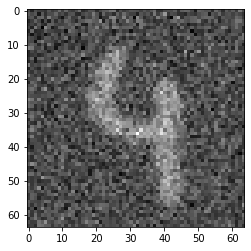

In [ ]:
x, y = next(iter(train_loader))

plt.imshow(x[0, 0].cpu().numpy(), cmap='gray')

# Plots

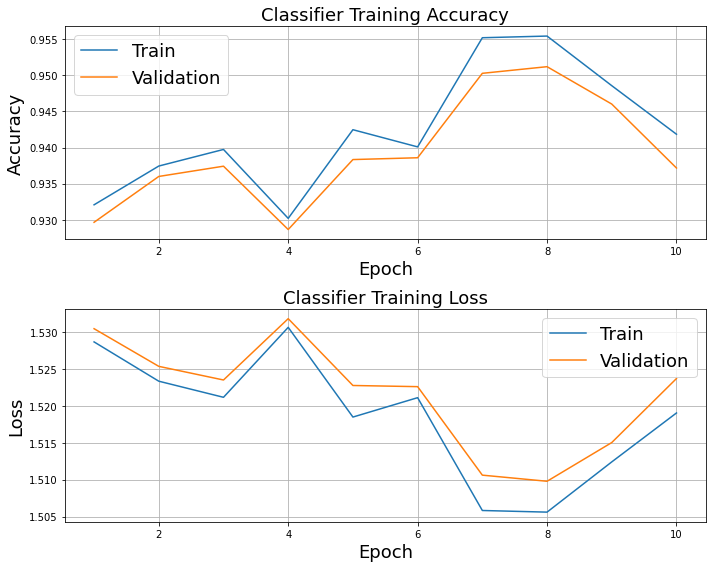

In [31]:
fig, ax = plt.subplots(2, 1, figsize=(10, 8))

ax[0].plot(range(1, C_epochs + 1), train_acc, label='Train')
ax[0].plot(range(1, C_epochs + 1), val_acc, label='Validation')
ax[0].set_title('Classifier Training Accuracy', fontsize=18)
ax[0].set_xlabel('Epoch', fontsize=18)
ax[0].set_ylabel('Accuracy', fontsize=18)
ax[0].grid()
ax[0].legend(fontsize=18)


ax[1].plot(range(1, C_epochs + 1), train_loss, label='Train')
ax[1].plot(range(1, C_epochs + 1), val_loss, label='Validation')
ax[1].set_title('Classifier Training Loss', fontsize=18)
ax[1].set_xlabel('Epoch', fontsize=18)
ax[1].set_ylabel('Loss', fontsize=18)
ax[1].grid()
ax[1].legend(fontsize=18)

fig.tight_layout()


# Encoder

In [ ]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(28*28 + 7*7, 28*28)
        self.fc2 = nn.Linear(28*28, 28*28)
        self.fc3 = nn.Linear(28*28, 28*28)
        # self.bn1 = nn.BatchNorm1d(28*28)
        self.relu = nn.ReLU()
    def forward(self, x, w):
        x = t.cat((x.view(-1, 28*28), w.view(-1, 7*7)), dim=-1)
        # x = self.relu(self.fc1(x))
        x = self.fc1(x)
        # x = self.relu(self.fc2(x))
        x = x.view(-1, 28, 28)
        return x        

# Training the Encoder

In [37]:
E_lr = 1e-3
E_epochs = 10

# E = Encoder().to(device)

E = mobilenetv3(input_size=64, num_classes=10, in_channels=1, drop_prob=0.0,
                get_weights=False, progress=True, device=device).to(device)
noiser = AddGaussianNoise(device=device)

C.eval()
criterion = nn.MSELoss()
optimizer = t.optim.Adam(E.parameters(), lr=E_lr) 

train_acc = [] 
val_acc = []
train_loss = []
val_loss = []

for epoch in range(E_epochs):
    start_time = time.time()
    E.train()   
    correct = 0
    train_total = 0
    train_tot_loss = 0
    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        x_noised = noiser(x)
        output = E(x_noised)
        optimizer.zero_grad()
        loss = criterion(output, x)
        loss.backward()
        optimizer.step()

    
    # train evaluation:
    E.eval()
    correct = 0
    train_total = 0
    train_tot_loss = 0
    with t.no_grad():
        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            x_noised = noiser(x)
            output = E(x_noised)
            loss = criterion(output, x) 
            train_tot_loss += loss.item()
            with t.no_grad():
              C_out = C(output)
            correct += (C_out.argmax(-1) == y).sum()
            train_total += len(y)
        train_loss.append(train_tot_loss/len(train_loader))
        train_acc.append(correct/train_total)

    
    # validation evaluation:
    E.eval()
    correct = 0
    val_total = 0
    val_tot_loss = 0
    with t.no_grad():
        for x, y in val_loader:
            x, y = x.to(device), y.to(device)
            x_noised = noiser(x)
            output = E(x_noised)
            loss = criterion(output, x) 
            val_tot_loss += loss.item()
            with t.no_grad():
              C_out = C(output)
            correct += (C_out.argmax(-1) == y).sum()
            val_total += len(y)
        val_loss.append(val_tot_loss/len(val_loader))
        val_acc.append(correct/val_total)

    end_time = time.time()
    print('[Epoch {}/{}] -> Train Loss: {:.3f}, Train Classifier Acc: {:.3f}, Validation Loss: {:.3f}, Validation Classifier Acc: {:.3f}, Time: {:.3f}'.format(
        epoch + 1, E_epochs, train_loss[-1], train_acc[-1],
        val_loss[-1], val_acc[-1], end_time - start_time))


[Epoch 1/10] -> Train Loss: 0.032, Train Classifier Acc: 0.933, Validation Loss: 0.032, Validation Classifier Acc: 0.932, Time: 513.471
[Epoch 2/10] -> Train Loss: 0.024, Train Classifier Acc: 0.944, Validation Loss: 0.024, Validation Classifier Acc: 0.941, Time: 513.785
[Epoch 3/10] -> Train Loss: 0.022, Train Classifier Acc: 0.940, Validation Loss: 0.023, Validation Classifier Acc: 0.935, Time: 511.570
[Epoch 4/10] -> Train Loss: 0.020, Train Classifier Acc: 0.940, Validation Loss: 0.020, Validation Classifier Acc: 0.936, Time: 511.611
[Epoch 5/10] -> Train Loss: 0.019, Train Classifier Acc: 0.944, Validation Loss: 0.019, Validation Classifier Acc: 0.939, Time: 512.329
[Epoch 6/10] -> Train Loss: 0.018, Train Classifier Acc: 0.941, Validation Loss: 0.018, Validation Classifier Acc: 0.938, Time: 514.974
[Epoch 7/10] -> Train Loss: 0.017, Train Classifier Acc: 0.945, Validation Loss: 0.017, Validation Classifier Acc: 0.941, Time: 514.347
[Epoch 8/10] -> Train Loss: 0.016, Train Classif

# Plots

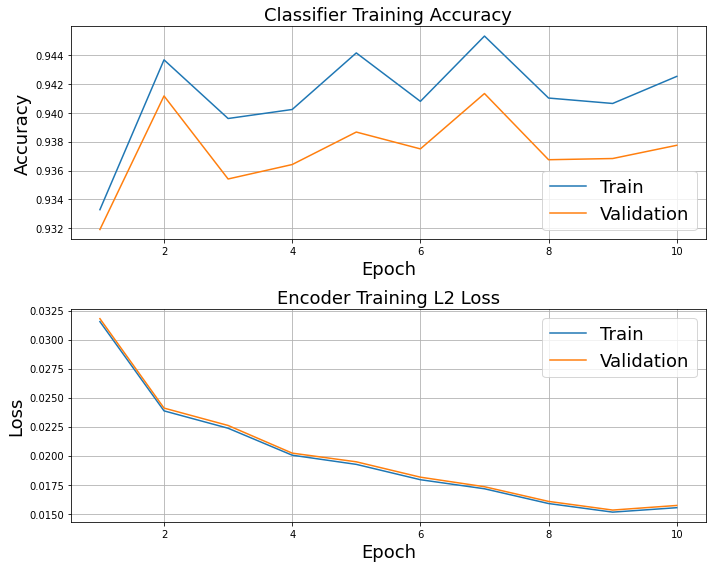

In [38]:
fig, ax = plt.subplots(2, 1, figsize=(10, 8))

ax[0].plot(range(1, E_epochs + 1), train_acc, label='Train')
ax[0].plot(range(1, E_epochs + 1), val_acc, label='Validation')
ax[0].set_title('Classifier Training Accuracy', fontsize=18)
ax[0].set_xlabel('Epoch', fontsize=18)
ax[0].set_ylabel('Accuracy', fontsize=18)
ax[0].grid()
ax[0].legend(fontsize=18)


ax[1].plot(range(1, E_epochs + 1), train_loss, label='Train')
ax[1].plot(range(1, E_epochs + 1), val_loss, label='Validation')
ax[1].set_title('Encoder Training L2 Loss', fontsize=18)
ax[1].set_xlabel('Epoch', fontsize=18)
ax[1].set_ylabel('Loss', fontsize=18)
ax[1].grid()
ax[1].legend(fontsize=18)

fig.tight_layout()


MSE: 0.01613832637667656


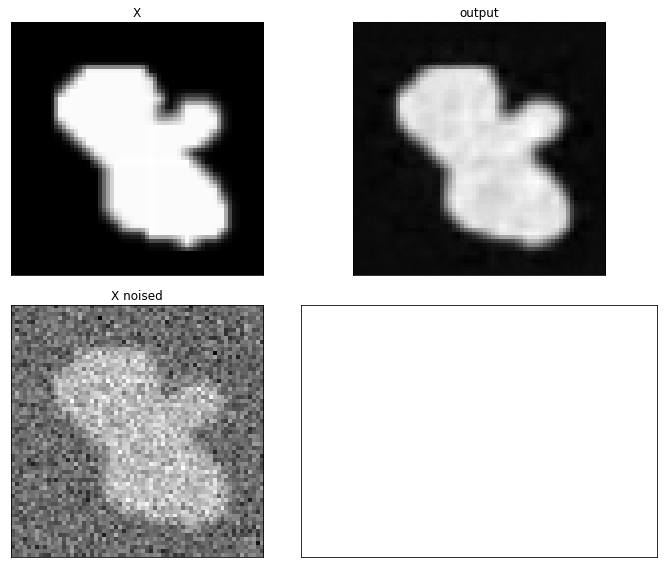

In [44]:
idx = 0
it = iter(train_loader)
x, y = it.next()
x = x.to(device)
x_noised = noiser(x)
x_noised = x_noised[[idx]]
x = x[[idx]]
E.eval()
with t.no_grad():
  out = E(x_noised)

fig, ax = plt.subplots(2, 2, figsize=(10, 8))

ax[0, 0].imshow(x[0][0].cpu(), cmap='gray')
ax[0, 0].set_title('X')

ax[1, 0].imshow(x_noised[0][0].cpu(), cmap='gray')
ax[1, 0].set_title('X noised')

ax[0, 1].imshow(out[0, 0].cpu(), cmap='gray')
ax[0, 1].set_title('output')

plt.setp(ax, xticks=[], yticks=[]);
fig.tight_layout()

mse = ((x - out)**2).mean()
print('MSE: ' + str(mse.item()))

# Net of Encoder - Decoder 

In [ ]:
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder,self).__init__()
        self.fc1 = nn.Linear(28*28, 1024)
        self.b1 = nn.BatchNorm1d(1024)
        self.fc2 = nn.Linear(1024, 512) 
        self.b2 = nn.BatchNorm1d(512)
        self.fc3 = nn.Linear(512, 10 + 1) # +1 since there is "other" class
        self.b3 = nn.BatchNorm1d(10 + 1)
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=-1)  

    def forward(self, img): 
        x = img.view(-1, 28*28)
        x = self.relu(self.b1(self.fc1(x)))
        x = self.relu(self.b2(self.fc2(x)))
        x = self.fc3(x)
        x = self.softmax(x)
        return x


class Net(nn.Module):
    def __init__(self, E_net=None):
        super(Net,self).__init__()
        if E_net is None:
            self.E = Encoder()
        else:
            self.E = E_net
        self.D = Decoder()
        
    def forward(self, img, w, y_w=None): 
        out_E = self.E(img, w)
        if y_w is not None:
            # training
            x, y_w = get_decoder_input(out_E.unsqueeze(1), img, y_w)
            out = self.D(x)
        else:
            print('Eval Mode')
            out = self.D(out_E)

        return out_E, out, y_w


# Training The Net

In [ ]:
# t.save(E.state_dict(), 'Encoder_dict')
# t.save(net.state_dict(), 'net_dict')

In [ ]:
E1 = copy.deepcopy(E)

In [ ]:
train_E = [2, 4, 2]
periods = [100, 150, 170]
period_ind = 0

net_lr = 1e-4
net_epochs = 10 # np.max(periods)

E_lr = 1e-5

In [ ]:
net = Net(E1).to(device)
C.eval()

criterion_E = nn.MSELoss()
criterion = nn.CrossEntropyLoss()

optimizer_E = t.optim.Adam(net.E.parameters(), lr = E_lr) 
optimizer = t.optim.Adam(net.parameters(), lr = net_lr) 

train_loss = {'D': [], 'E': []}
train_acc = {'D': [], 'C': []}
val_loss = {'D': [], 'E': []}
val_acc = {'D': [], 'C': []}

print('Period: 0')
for epoch in range(net_epochs):
    if epoch >= periods[period_ind]:
        period_ind += 1
        print('Period: ' + str(period_ind))
    start_time = time.time()
    
    net.train()   
    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        random_roll = t.randint(100, (1, ))
        w = F.interpolate(t.roll(x, random_roll.item(), 0), (7,7), mode='area')
        y_w = t.roll(y, random_roll.item(), 0)
        out_E, out, y_w = net(x, w, y_w)
        loss_E = criterion_E(out_E.unsqueeze(1), x)
        loss = criterion(out, y_w)

        unite_loss = unite_losses(loss_E, loss)
        optimizer.zero_grad()
        unite_loss.backward()
        optimizer.step()

        # if  False:#epoch % train_E[period_ind] == 0:
        #     optimizer_E.zero_grad()
        #     loss_E.backward()
        #     optimizer_E.step()
        # else:    
        #     optimizer.zero_grad()
        #     loss.backward()
        #     optimizer.step()
        

    
    # train evaluation:
    net.eval()
    train_acc['D'].append(0)
    train_acc['C'].append(0)
    train_loss['D'].append(0)
    train_loss['E'].append(0)
    correct = 0
    train_total = 0
    train_tot_loss = 0
    with t.no_grad():
        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            random_roll = t.randint(100, (1, ))
            w = F.interpolate(t.roll(x, random_roll.item(), 0), (7,7), mode='area')
            y_w = t.roll(y, random_roll.item(), 0)
            out_E, out, y_w = net(x, w, y_w)
            out_C = C(out_E.unsqueeze(1))
            train_loss['E'][-1] += criterion_E(out_E.unsqueeze(1), x).item()
            train_loss['D'][-1] += criterion(out, y_w).item()
            train_acc['D'][-1] += (out.argmax(-1) == y_w).sum()
            train_acc['C'][-1] += (out_C.argmax(-1) == y).sum()

            train_total += len(y)
        
        train_acc['C'][-1] = train_acc['C'][-1]/train_total
        train_acc['D'][-1] = train_acc['D'][-1]/train_total
        train_loss['D'][-1] = train_loss['D'][-1] /len(train_loader)
        train_loss['E'][-1] = train_loss['E'][-1] /len(train_loader)


    # validation evaluation:
    net.eval()
    val_acc['D'].append(0)
    val_acc['C'].append(0)
    val_loss['D'].append(0)
    val_loss['E'].append(0)
    correct = 0
    val_total = 0
    val_tot_loss = 0
    with t.no_grad():
        for x, y in val_loader:
            x, y = x.to(device), y.to(device)
            random_roll = t.randint(100, (1, ))
            w = F.interpolate(t.roll(x, random_roll.item(), 0), (7,7), mode='area')
            y_w = t.roll(y, random_roll.item(), 0)
            out_E, out, y_w = net(x, w, y_w)
            out_C = C(out_E)
            val_loss['E'][-1] += criterion_E(out_E.unsqueeze(1), x).item()
            val_loss['D'][-1] += criterion(out, y_w).item()
            val_acc['D'][-1] += (out.argmax(-1) == y_w).sum()
            val_acc['C'][-1] += (out_C.argmax(-1) == y).sum()

            val_total += len(y)
        
        val_acc['C'][-1] = val_acc['C'][-1]/val_total
        val_acc['D'][-1] = val_acc['D'][-1]/val_total
        val_loss['D'][-1] = val_loss['D'][-1] /len(val_loader)
        val_loss['E'][-1] = val_loss['E'][-1] /len(val_loader)

    end_time = time.time()
    print('[Epoch {}/{}] -> E Train Loss: {:.5f}, C Train Acc: {:.3f}, D Train Loss: {:.3f}, D Train Acc: {:.3f}, E Val Loss: {:.3f}, C Val Acc: {:.3f}, D Val Loss: {:.3f}, D Val Acc: {:.3f}, Time: {:.3f}'.format(
        epoch + 1, net_epochs, train_loss['E'][-1], train_acc['C'][-1], train_loss['D'][-1], train_acc['D'][-1], val_loss['E'][-1], val_acc['C'][-1], val_loss['D'][-1], val_acc['D'][-1], end_time - start_time))
    print(unite_loss)

Period: 0
[Epoch 1/10] -> E Train Loss: 0.00056, C Train Acc: 0.980, D Train Loss: 1.719, D Train Acc: 0.834, E Val Loss: 0.001, C Val Acc: 0.971, D Val Loss: 1.718, D Val Acc: 0.835, Time: 14.777
tensor(0.1771, device='cuda:0', grad_fn=<AddBackward0>)
[Epoch 2/10] -> E Train Loss: 0.00054, C Train Acc: 0.980, D Train Loss: 1.711, D Train Acc: 0.842, E Val Loss: 0.001, C Val Acc: 0.970, D Val Loss: 1.709, D Val Acc: 0.843, Time: 15.383
tensor(0.1734, device='cuda:0', grad_fn=<AddBackward0>)
[Epoch 3/10] -> E Train Loss: 0.00056, C Train Acc: 0.980, D Train Loss: 1.710, D Train Acc: 0.844, E Val Loss: 0.001, C Val Acc: 0.971, D Val Loss: 1.709, D Val Acc: 0.842, Time: 14.801
tensor(0.1736, device='cuda:0', grad_fn=<AddBackward0>)
[Epoch 4/10] -> E Train Loss: 0.00056, C Train Acc: 0.980, D Train Loss: 1.707, D Train Acc: 0.842, E Val Loss: 0.001, C Val Acc: 0.971, D Val Loss: 1.707, D Val Acc: 0.843, Time: 14.531
tensor(0.1771, device='cuda:0', grad_fn=<AddBackward0>)
[Epoch 5/10] -> E 

# Plots

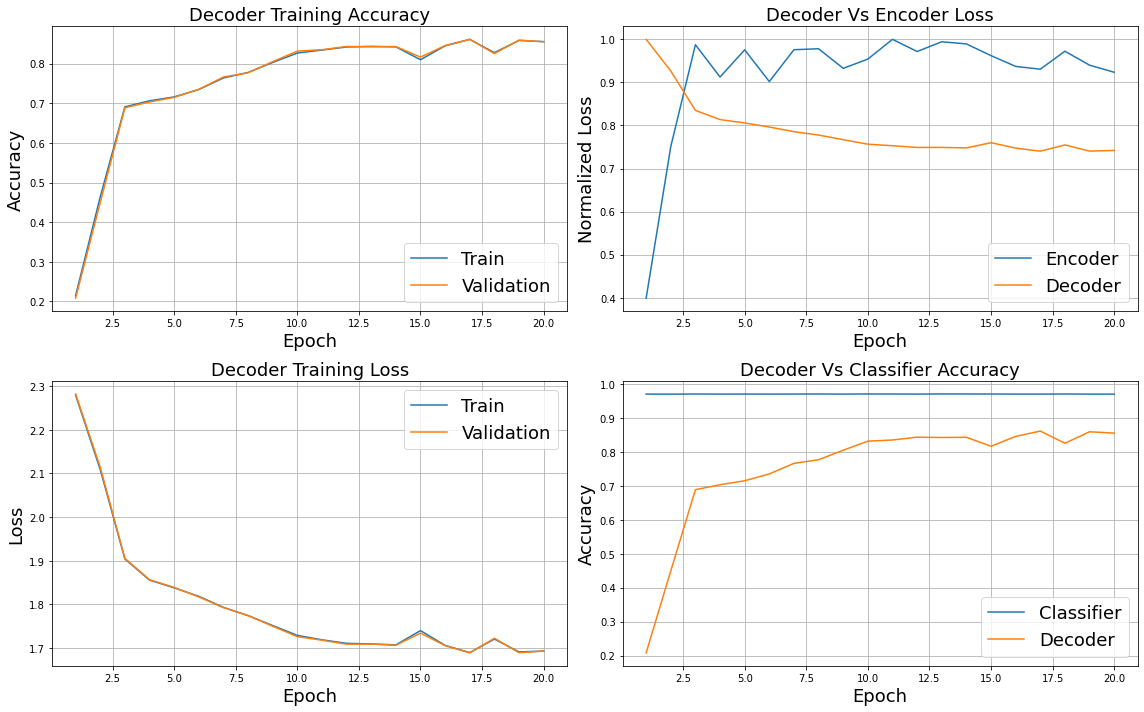

In [ ]:
fig, ax = plt.subplots(2, 2, figsize=(16, 10))

net_epochs = len(train_acc['D'])
ax[0, 0].plot(range(1, net_epochs + 1), train_acc['D'], label='Train')
ax[0, 0].plot(range(1, net_epochs + 1), val_acc['D'], label='Validation')
ax[0, 0].set_title('Decoder Training Accuracy', fontsize=18)
ax[0, 0].set_xlabel('Epoch', fontsize=18)
ax[0, 0].set_ylabel('Accuracy', fontsize=18)
ax[0, 0].grid()
ax[0, 0].legend(fontsize=18)
# ax[0, 0].set_ylim([0, 1])


ax[1, 0].plot(range(1, net_epochs + 1), train_loss['D'], label='Train')
ax[1, 0].plot(range(1, net_epochs + 1), val_loss['D'], label='Validation')
ax[1, 0].set_title('Decoder Training Loss', fontsize=18)
ax[1, 0].set_xlabel('Epoch', fontsize=18)
ax[1, 0].set_ylabel('Loss', fontsize=18)
ax[1, 0].grid()
ax[1, 0].legend(fontsize=18)
# ax[1, 0].set_ylim([1.5, 2])

ax[0, 1].plot(range(1, net_epochs + 1), val_loss['E']/np.max(val_loss['E']), label='Encoder')
ax[0, 1].plot(range(1, net_epochs + 1), val_loss['D']/np.max(val_loss['D']), label='Decoder')
ax[0, 1].set_title('Decoder Vs Encoder Loss', fontsize=18)
ax[0, 1].set_xlabel('Epoch', fontsize=18)
ax[0, 1].set_ylabel('Normalized Loss', fontsize=18)
ax[0, 1].grid()
ax[0, 1].legend(fontsize=18)
# ax[0, 1].set_ylim([0, 0.6])

ax[1, 1].plot(range(1, net_epochs + 1), val_acc['C'], label='Classifier')
ax[1, 1].plot(range(1, net_epochs + 1), val_acc['D'], label='Decoder')
ax[1, 1].set_title('Decoder Vs Classifier Accuracy', fontsize=18)
ax[1, 1].set_xlabel('Epoch', fontsize=18)
ax[1, 1].set_ylabel('Accuracy', fontsize=18)
ax[1, 1].grid()
ax[1, 1].legend(fontsize=18)
# ax[1, 1].set_ylim([0.5, 1])
# ax[1, 1].set_ylim([0, 1])

fig.tight_layout()


MSE: 0.0004951673909090459
Classifier prediction: 4
Decoder prediction: 2


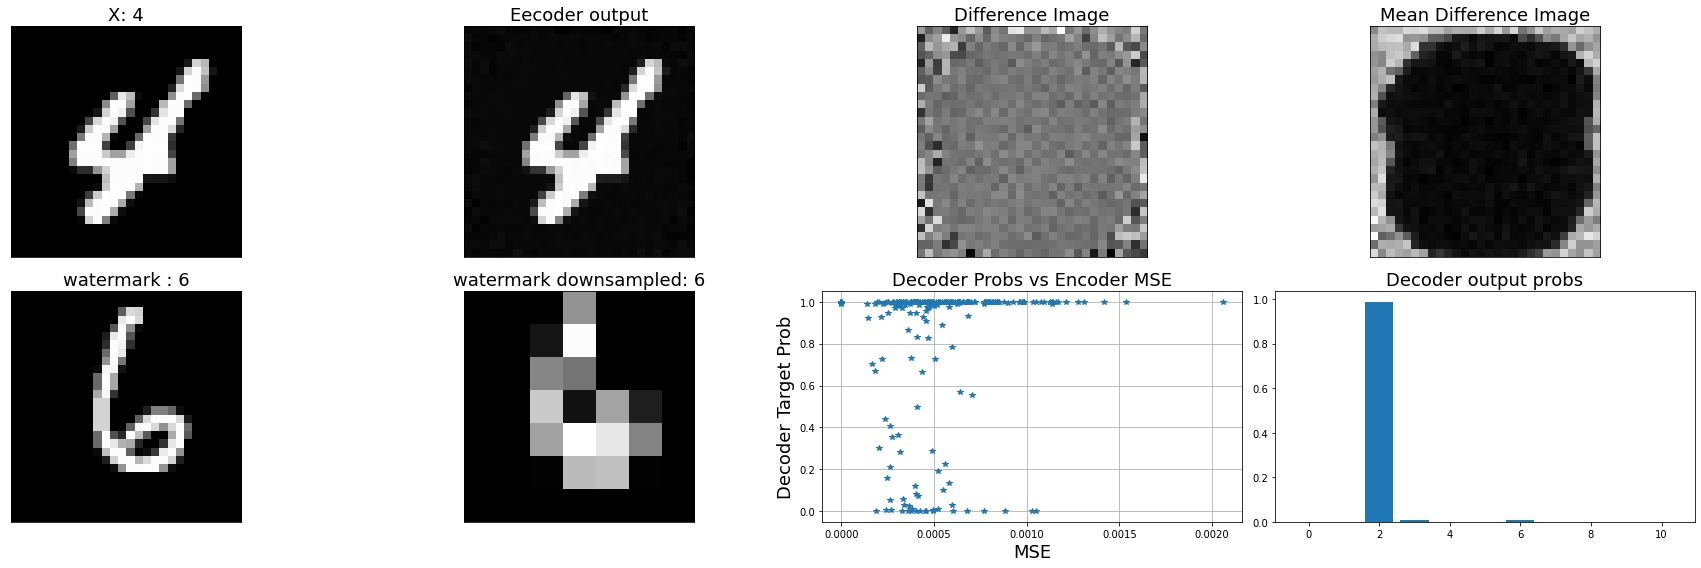

In [ ]:
idx = 0
it = iter(train_loader)
x, y = it.next()
x, y = x.to(device), y.to(device)

watermark = t.roll(x, 1, 0)
w = F.interpolate(watermark, (7,7), mode='area')
y_w = t.roll(y, 1, 0)

net.E.eval()
net.D.eval()
with t.no_grad():
    out_E = net.E(x, w)
    out_E_processed, y_w = get_decoder_input(out_E.unsqueeze(1), x, y_w)
    out_E_processed = out_E_processed.squeeze(1)
    C_pred = C(out_E_processed).argmax(1)
    out = net.D(out_E_processed)

fig, ax = plt.subplots(2, 4, figsize=(25, 8))

ax[0, 0].imshow(x[idx][0].cpu(), cmap='gray')
ax[0, 0].set_title('X: ' + str(y[idx].item()), fontsize=18)
ax[0, 0].set_xticks([])
ax[0, 0].set_yticks([])

ax[1, 1].imshow(w[idx][0].cpu(), cmap='gray')
ax[1, 1].set_title('watermark downsampled: ' + str(y_w[idx].item()), fontsize=18)
ax[1, 1].set_xticks([])
ax[1, 1].set_yticks([])

ax[1, 0].imshow(watermark[idx][0].cpu(), cmap='gray')
ax[1, 0].set_title('watermark : ' + str(y_w[idx].item()), fontsize=18)
ax[1, 0].set_xticks([])
ax[1, 0].set_yticks([])

ax[0, 1].imshow(out_E[idx].cpu(), cmap='gray')
ax[0, 1].set_title('Eecoder output', fontsize=18)
ax[0, 1].set_xticks([])
ax[0, 1].set_yticks([])

ax[1, 3].bar(range(0, 11), out[idx].cpu())
ax[1, 3].set_title('Decoder output probs', fontsize=18)

ax[0, 2].imshow((x[idx][0] - out_E[idx]).cpu(), cmap='gray')
ax[0, 2].set_title('Difference Image', fontsize=18)
ax[0, 2].set_xticks([])
ax[0, 2].set_yticks([])

ax[0, 3].imshow(t.mean(t.abs(x.squeeze(1) - out_E_processed), dim=0).cpu(), cmap='gray')
ax[0, 3].set_title('Mean Difference Image', fontsize=18)
ax[0, 3].set_xticks([])
ax[0, 3].set_yticks([])

# plt.setp(ax, xticks=[], yticks=[]);

mse = t.mean((x.squeeze(1) - out_E)**2, [1, 2])

ax[1, 2].plot(mse.cpu(), out[range(len(y_w)), y_w].cpu(), '*')
ax[1, 2].set_title('Decoder Probs vs Encoder MSE', fontsize=18)
ax[1, 2].grid()
ax[1, 2].set_xlabel('MSE', fontsize=18)
ax[1, 2].set_ylabel('Decoder Target Prob', fontsize=18)




print('MSE: ' + str(mse[idx].item()))

print('Classifier prediction: ' + str(C_pred[idx].item()))
print('Decoder prediction: ' + str(out[idx].argmax().item()))

fig.tight_layout()

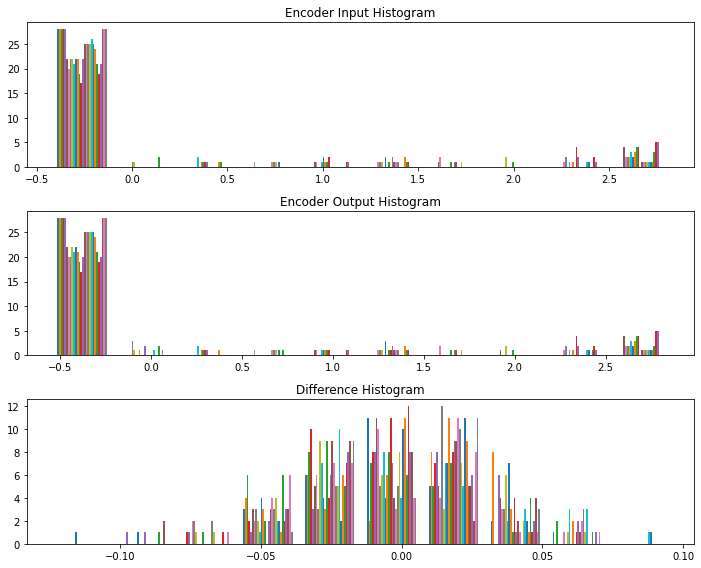

In [ ]:
# Image Histograms:
idx = 4

fig, ax = plt.subplots(3, 1, figsize=(10, 8))

ax[0].hist(x[idx][0].cpu())
ax[0].set_title('Encoder Input Histogram')

ax[1].hist(out_E[idx].cpu())
ax[1].set_title('Encoder Output Histogram')

ax[2].hist((out_E[idx] - x[idx][0]).cpu())
ax[2].set_title('Difference Histogram')

fig.tight_layout()

Normalized confusion matrix


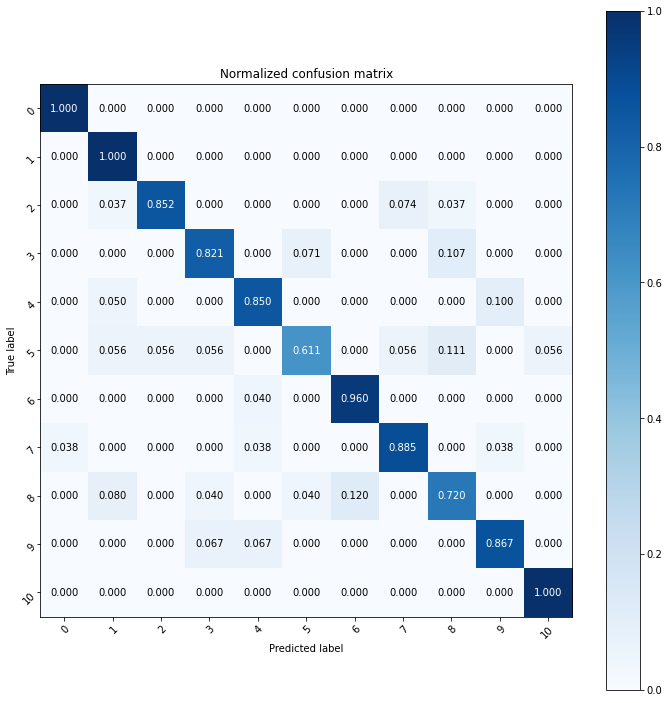

In [ ]:
plot_confusion_matrix(y_w.cpu(), out.argmax(1).cpu(), classes=np.arange(11),
                          normalize=True,
                          title=None,
                          cmap=plt.cm.Blues)

# Training The Decoder Separately

In [ ]:
D_lr = 1e-4
D_epochs = 150


D = Decoder().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = t.optim.Adam(D.parameters(), lr=D_lr) 

train_acc = []
val_acc = []
train_loss = []
val_loss = []
val_min_loss = np.inf

E.eval()
for epoch in range(D_epochs):
    start_time = time.time()
    D.train()   
    correct = 0
    train_total = 0
    train_tot_loss = 0
    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        random_roll = t.randint(100, (1, ))
        w = F.interpolate(t.roll(x, random_roll.item(), 0), (7,7), mode='area')
        y_w = t.roll(y, random_roll.item(), 0)
        
        with t.no_grad():
            out_E = E(x, w)
        x, y = get_decoder_input(out_E.unsqueeze(1), x, y_w)
        optimizer.zero_grad()
        output = D(x)
        loss = criterion(output, y)
        loss.backward()
        train_tot_loss += loss.item()
        correct += (output.argmax(-1) == y).sum()
        train_total += len(y)
        optimizer.step()
    train_acc.append(correct/train_total)
    train_loss.append(train_tot_loss/len(train_loader))
    
    # validation evaluation:   
    D.eval()
    correct = 0
    val_total = 0
    val_tot_loss = 0
    with t.no_grad():
        for x, y in val_loader:
            x, y = x.to(device), y.to(device)
            random_roll = t.randint(100, (1, ))
            w = F.interpolate(t.roll(x, random_roll.item(), 0), (7,7), mode='area')
            y_w = t.roll(y, random_roll.item(), 0)
            with t.no_grad():
                out_E = E(x, w)
            x, y = get_decoder_input(out_E.unsqueeze(1), x, y_w)
            output = D(x)
            loss = criterion(output, y)
            val_tot_loss += loss.item()
            correct += (output.argmax(-1) == y).sum()
            val_total += len(y)
        val_loss.append(val_tot_loss/len(val_loader))
        val_acc.append(correct/val_total)


    end_time = time.time()
    print('[Epoch {}/{}] -> Train Loss: {:.3f}, Train Acc: {:.3f}, Validation Loss: {:.3f}, Validation Acc: {:.3f}, Time: {:.3f}'.format(
        epoch + 1, D_epochs, train_tot_loss, train_acc[-1],
        val_tot_loss, val_acc[-1], end_time - start_time))


# Use Pre-trained Nets

In [ ]:
# net = Net().to(device)
# net.load_state_dict(t.load('net_dict'))

C = Classifier().to(device)
C.load_state_dict(t.load('Classifier_dict'))

E = Encoder().to(device)
E.load_state_dict(t.load('Encoder_dict'))


<All keys matched successfully>